# クローバー動作解析

## CSVファイルの読み込み

In [69]:
using Plots
using DataFrames
using CSV
using LsqFit
using LaTeXStrings
using QuadGK

df = CSV.read("data/D05AB_SC90.CSV", DataFrame)

df1 = df[df.Time.>0,:]
#dft1 = df1[df1.Volt.>=maximum(df1.Volt), :]
#t1 = dft1.Time[1]
t1 = df1[df1.Volt.>=maximum(df1.Volt), :].Time[1]
df2 = df1[df1.Time.< t1.Time, :]
plot(df2.Time*1e6, df2.Volt*800/1e3, label="Before Crowbar work")
df3 = df1[df1.Time.>= t1.Time, :]
plot!(df3.Time*1e6, df3.Volt*800/1e3, label="After Crowbar work")
xlabel!(L"Time [$\mu s$]")
ylabel!("Current [kA]")
#savefig("plot1.pdf")


ErrorException: type Float64 has no field Time

### フィッティングモデルの定義
$$
i_1(t) = A\left( e^{\lambda_1 t} - e^{\lambda_2 t} \right)\;,\; i_2(t) = I_0 e^{-(t - t_1)/\tau}
$$

Fitted Parameters1: [6448.844103076778, -23975.693380992132, -289741.83189261606]
Fitted Parameters2: [4094.6211372357125, 1.4565919331726543e-5]


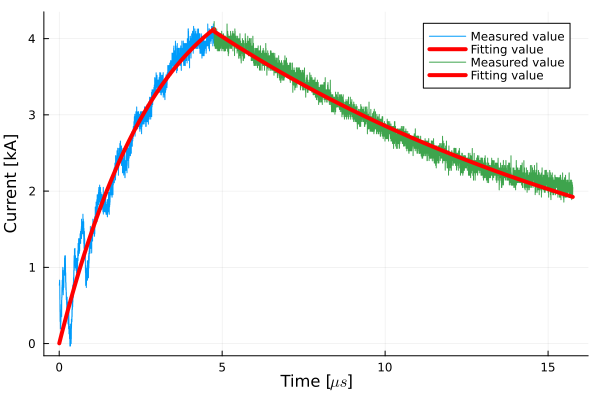

In [70]:
# モデルの定義
i1(t, p) = @. p[1] * (exp(p[2]*t) - exp(p[3]*t))
#i2(t, q) = @. q[1] * exp(-((t - q[3])/q[2]))
i2(t, q) = @. q[1] * exp(-((t - t1)/q[2]))

# 初期パラメータの推測
initial_params1 = [6400, 1e-6, 1]
#initial_params2 = [5300,17e-6,0]
initial_params2 = [5300,17e-6]

# フィッティングの実行
fit_result1 = curve_fit(i1, df2.Time, df2.Volt*800, initial_params1)
fit_result2 = curve_fit(i2, df3.Time, df3.Volt*800, initial_params2)

# フィッティングされたパラメータ
fitted_params1 = fit_result1.param
println("Fitted Parameters1: ", fitted_params1)
fitted_params2 = fit_result2.param
println("Fitted Parameters2: ", fitted_params2)

# フィッティング結果を使用してy値を計算
yfit1 = i1(df2.Time, fitted_params1)
yfit2 = i2(df3.Time, fitted_params2)

plot(df2.Time*1e6, df2.Volt*800/1e3, label="Measured value")
plot!(df2.Time*1e6 ,yfit1/1e3, label="Fitting value",linewidth=4, linecolor = :red)
plot!(df3.Time*1e6, df3.Volt*800/1e3, label="Measured value")
plot!(df3.Time*1e6 ,yfit2/1e3, label="Fitting value", linewidth=4, linecolor = :red)
xlabel!(L"Time [$\mu s$]")
ylabel!("Current [kA]")

#savefig("plot2.pdf")

### 銅細線で消費されるエネルギー
$$
Q = \int R i(t)^2dt = \int_{0}^{t_1} R i_1(t)^2dt + \int_{0}^{t_1} R i_2(t)^2dt 
$$

In [72]:
# 銅細線で消費されるエネルギー
R = 0.035
A = fitted_params1[1]
λ1 = fitted_params1[2]
λ2 = fitted_params1[3]
Q1 = R*A^2*(exp(2*λ1*t1)/(2*λ1) - 2/(λ1+λ2)*exp((λ1+λ2)*t1) + exp(2*λ2*t1)/(2*λ2) - 1/(2*λ1)+ 2/(λ1+λ2) - 1/(2*λ2))
println("Energy consumption: ", Q1, "[J]")

I0 = fitted_params2[1]
τ = fitted_params2[2]
#t2 = fitted_params2[3]

Q2 = R*I0^2*τ/2
println("Energy consumption: ", Q2, "[J]")
println("Total consumption: ", Q1+Q2, "[J]")

#println("t1: ",t1, " t2 ", t2)

Energy consumption: 1.3486621337085656[J]
Energy consumption: 4.273693744682371[J]
Total consumption: 5.622355878390936[J]
t0: 4.754e-6 t2 5.158956862202522e-7


A: 5512.409541401488 λ1: -4052.3448564804276 λ2: -309665.18041712773 L: 5.312634878185674e-5


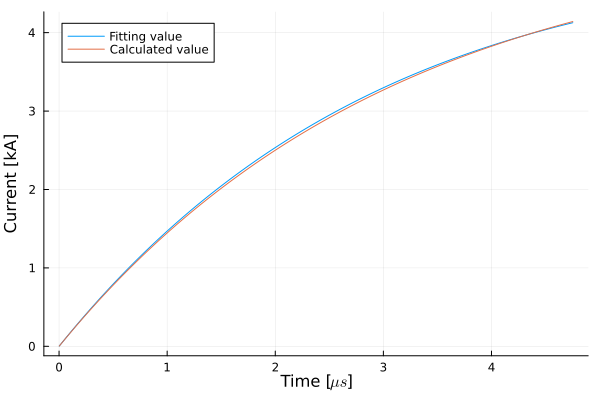

In [73]:
R1 = 70/6 + 5
L = - R1 /(fitted_params1[2] + fitted_params1[3])
C = 15e-6
V0 = 89.5e3

λ11 = -(R1/(2L))+sqrt((R1/2L)^2 - 1/(L*C))
λ22 = -(R1/(2L))-sqrt((R1/2L)^2 - 1/(L*C))
β = (λ11 - λ22)/2
A1 = V0/(2*β*L)

println("A: ", A1, " λ1: " , λ11, " λ2: ", λ22, " L: ", L)

ycal1 = i1(df2.Time, [A1, λ11, λ22])

#plot(df2.Time, df2.Volt*800)
plot(df2.Time*1e6 ,yfit1/1e3, label="Fitting value")
plot!(df2.Time*1e6 ,ycal1/1e3, label="Calculated value")
xlabel!(L"Time [$\mu s$]")
ylabel!("Current [kA]")

L: 72.82959665863271 [uH]


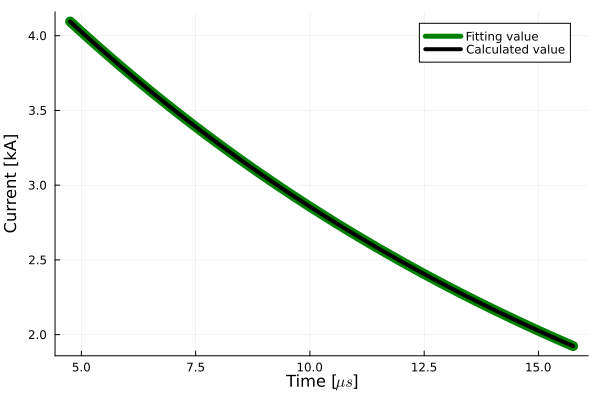

In [74]:
I0 = fitted_params2[1]
τ = fitted_params2[2]
#t3 =  fitted_params2[3]
Lcal = 5 * τ

println("L: ", Lcal*1e6, " [uH]")

#ycal2 = i2(df3.Time, [I0, τ, t3])
ycal2 = i2(df3.Time, [I0, τ])

plot(df3.Time*1e6 ,yfit2/1e3, linewidth=10, linecolor="green", label="Fitting value")
plot!(df3.Time*1e6 ,ycal2/1e3, linewidth=4,linecolor="black",label="Calculated value")
xlabel!(L"Time [$\mu s$]")
ylabel!("Current [kA]")

In [63]:

f(x) = R*(A * (exp(λ1 *x) - exp(λ2 *x)))^2

g(x) = R*(I0* exp(-((x - t1)/τ)))^2

quadgk(f, 0, t1)
quadgk(g, t1, 1)
#quadgk(g, t3, 1)

(4.273693744682371, 1.9156810426687238e-10)